Derivatives Pricing

The goal of this case study is to perform derivative pricing from a machine learning standpoint and use supervised regression-based model to learn the Black-Scholes option pricing model from simulated data.

In [1]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm
from scipy.stats import norm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

project_dir = "/Users/zoindia01/Downloads/Projects/RL_Finance/"

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

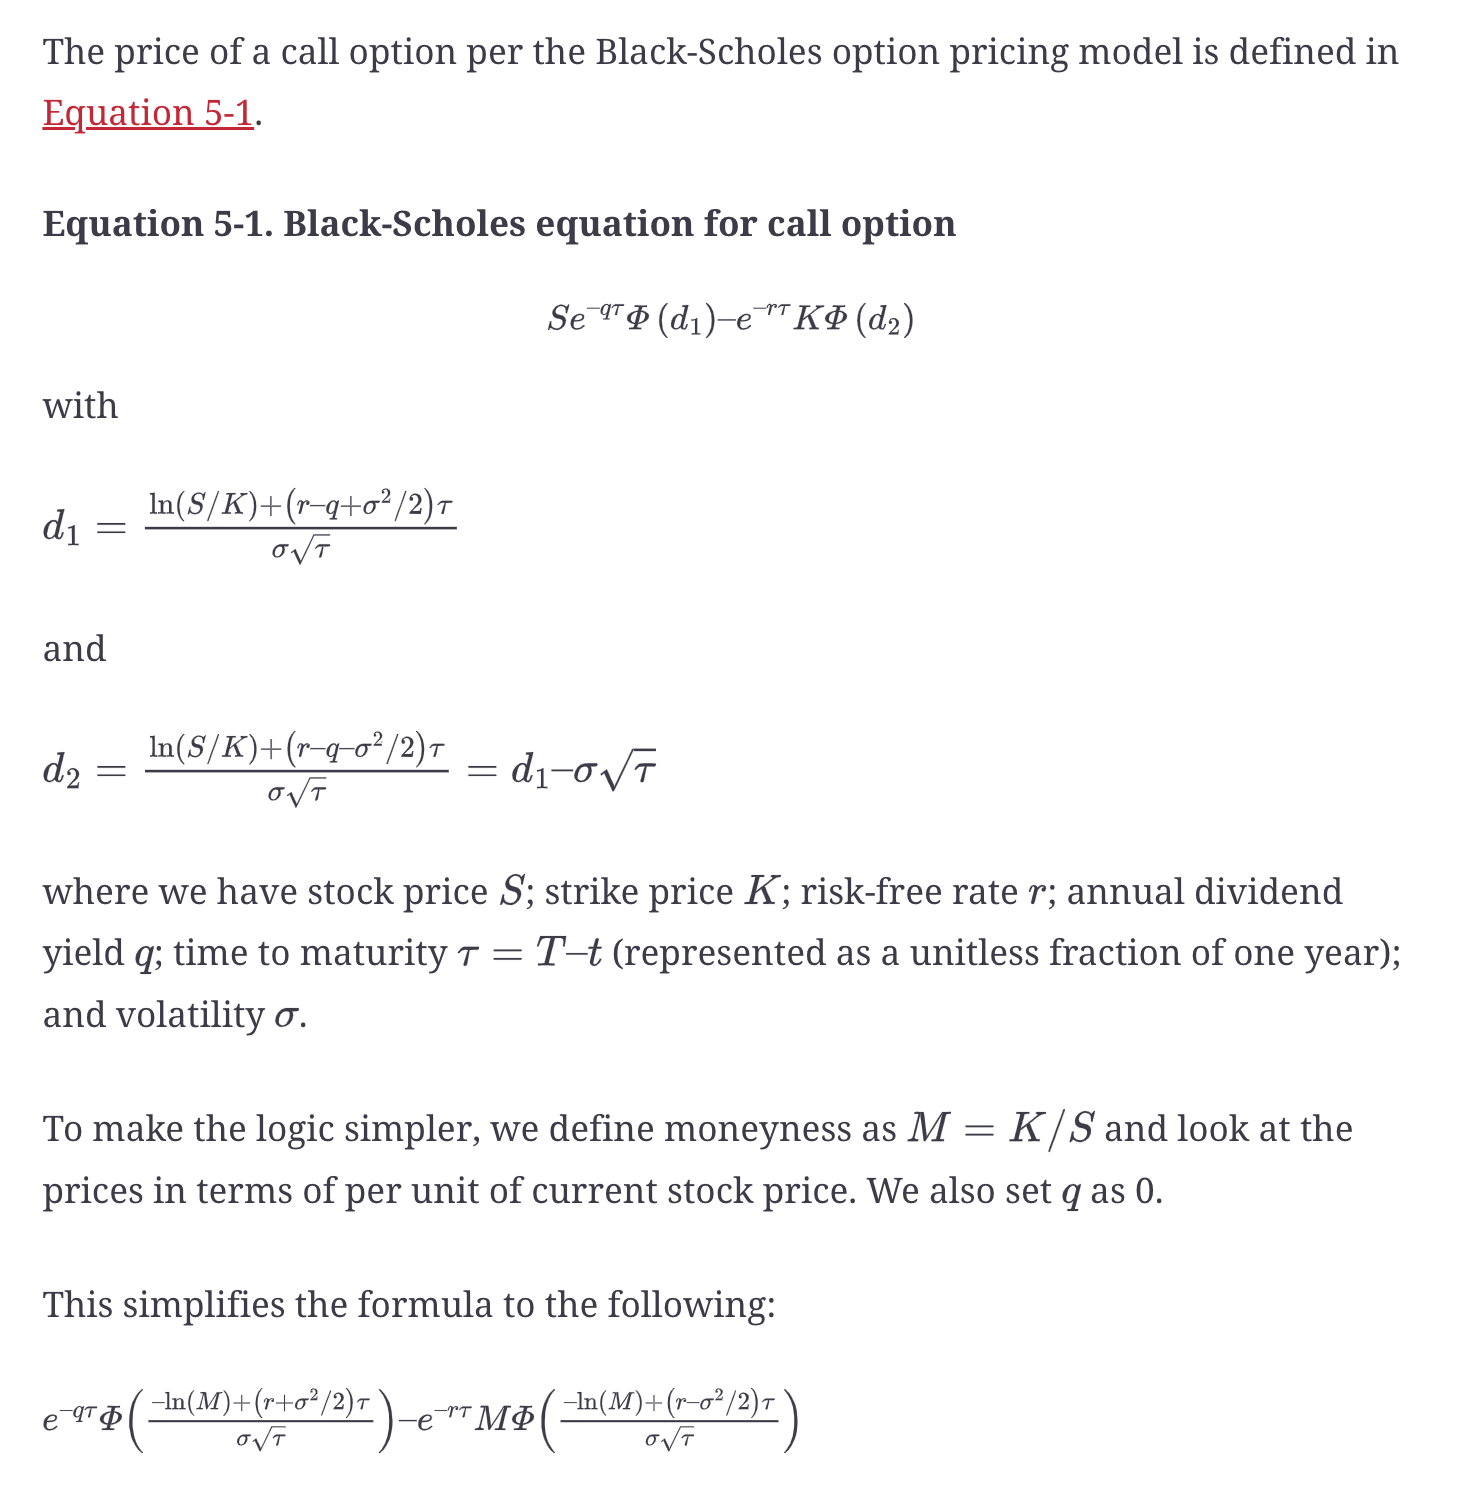

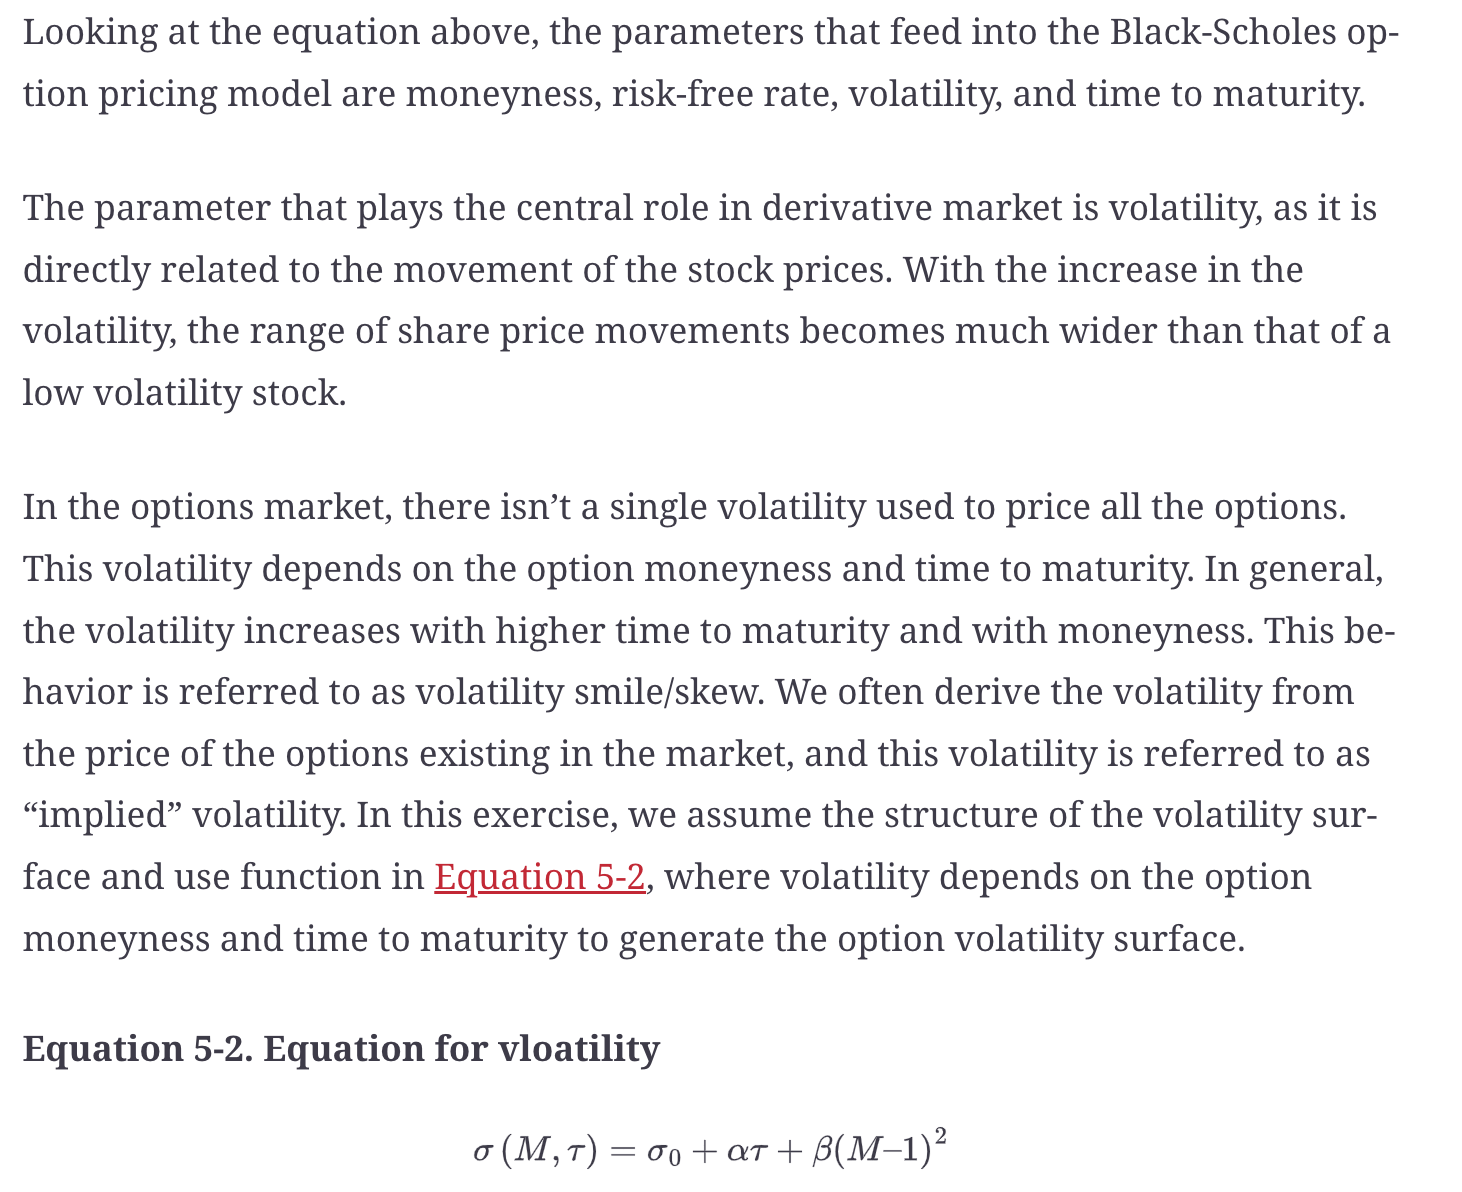

In [3]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

In [4]:
risk_free_rate = 0.05

In [7]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity +\
     true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

In [8]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])
#Ys and Xs

In [9]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

In [10]:
dataset = dataset.dropna()

In [11]:
dataset.head()

,Price,Moneyness,Time,Vol
0,2.074658e-01,1.064226,0.886802,0.289093
1,5.747072e-02,1.135897,0.332739,0.235121
2,5.700544e-02,0.958753,0.045438,0.204714
3,1.303090e-07,1.285611,0.055784,0.213736
4,8.002013e-02,1.453248,0.828644,0.303408


In [12]:
pd.set_option('precision', 3)
dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000,10000.000,1.000e+04,10000.000
mean,0.176,1.005,4.985e-01,0.256
std,0.135,0.252,2.883e-01,0.030
min,0.000,0.175,1.662e-04,0.200
25%,0.071,0.834,2.462e-01,0.231
50%,0.158,1.003,4.977e-01,0.256
75%,0.252,1.173,7.478e-01,0.281
max,0.832,1.900,1.000e+00,0.372


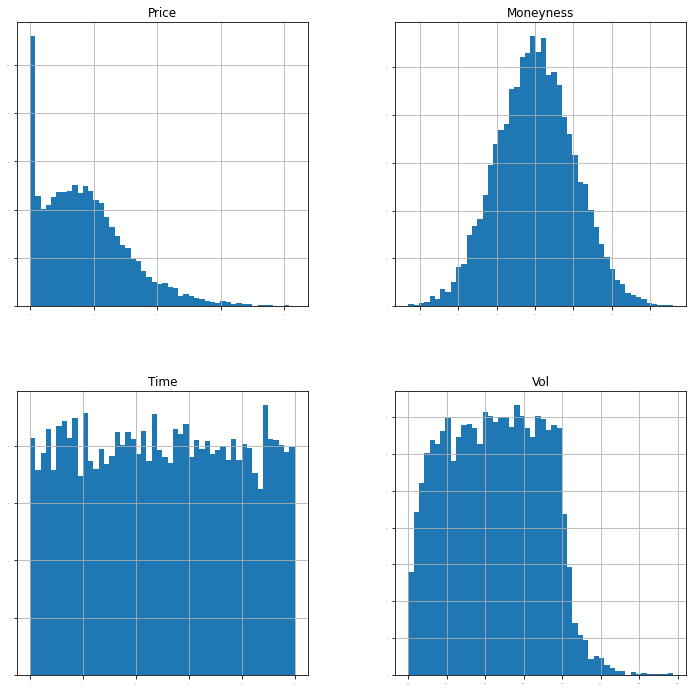

In [13]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

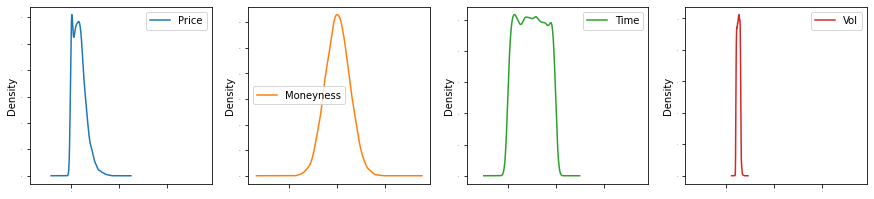

In [14]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

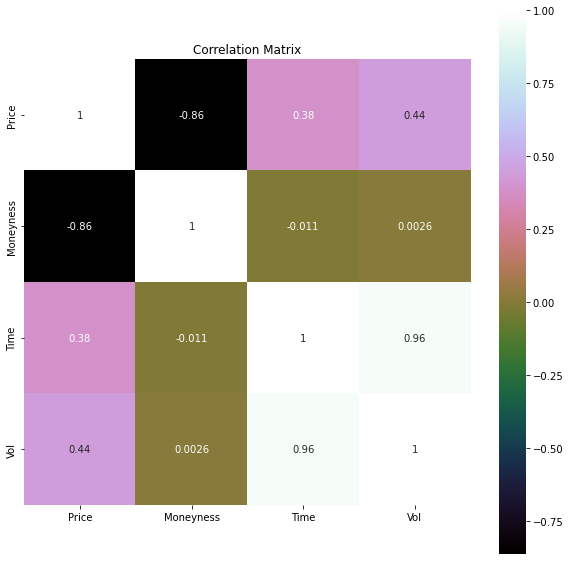

In [15]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

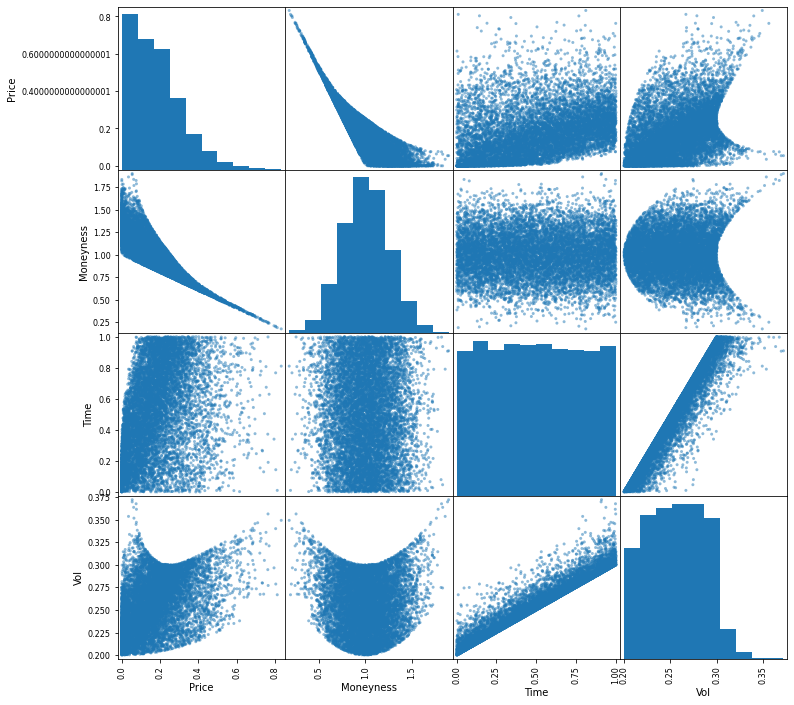

In [16]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

In [17]:
np.any(np.isnan(X))

False

In [18]:
np.all(np.isfinite(X))

True

In [19]:
np.any(np.isfinite(X))

True

In [20]:
dataset.isnull().any()

Price        False
Moneyness    False
Time         False
Vol          False
dtype: bool

In [21]:
col_name = dataset.columns.to_series()[np.isinf(dataset).any()]
print(col_name)

Series([], dtype: object)


In [22]:
dataset.columns

Index(['Price', 'Moneyness', 'Time', 'Vol'], dtype='object')

In [23]:
X =( dataset[['Moneyness', 'Time', 'Vol']]).to_numpy()
Y =( dataset[['Price']]).to_numpy()

In [24]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,29448.465
Vol,2463.129
Time,1723.441


In [25]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [26]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [27]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [28]:
models.append(('MLP', MLPRegressor()))

In [29]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [30]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000357 (0.000033) 0.000356 0.000339
LASSO: 0.018350 (0.000511) 0.018349 0.017419
EN: 0.018354 (0.001651) 0.018349 0.017419
KNN: 0.000016 (0.000009) 0.000008 0.000014
CART: 0.000010 (0.000001) 0.000000 0.000009
SVR: 0.004800 (0.000126) 0.004800 0.004694
MLP: 0.000034 (0.000016) 0.000028 0.000024
ABR: 0.000574 (0.000023) 0.000640 0.000636
GBR: 0.000022 (0.000001) 0.000019 0.000023
RFR: 0.000002 (0.000001) 0.000000 0.000002
ETR: 0.000001 (0.000001) 0.000000 0.000000


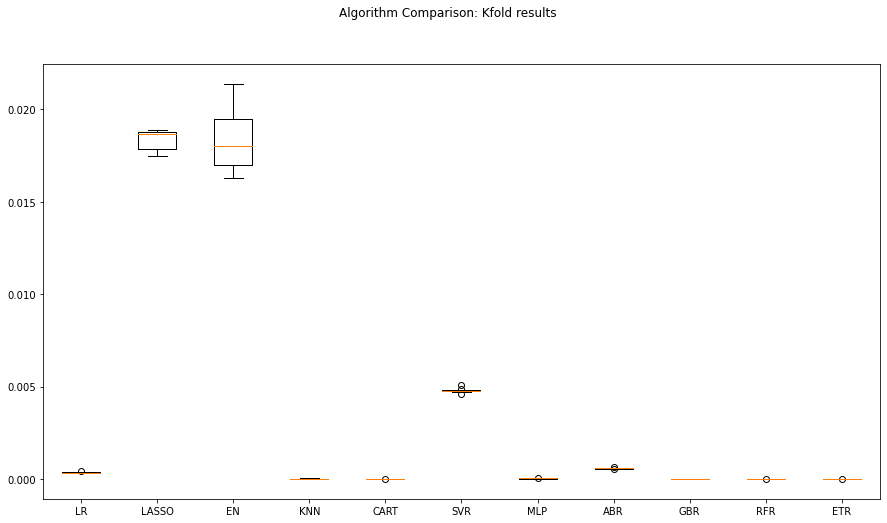

In [31]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

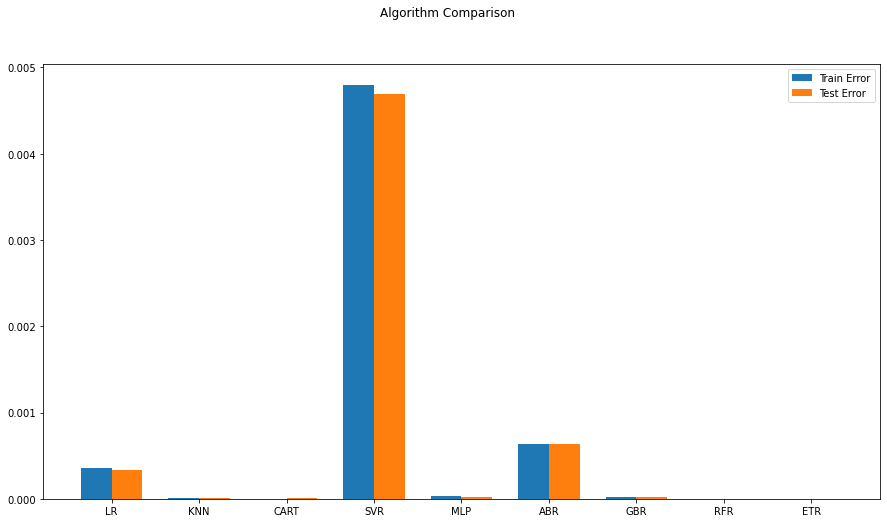

In [32]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

In [33]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000020 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000750 (0.000659) with: {'hidden_layer_sizes': (20,)}
-0.000224 (0.000350) with: {'hidden_layer_sizes': (50,)}
-0.000145 (0.000163) with: {'hidden_layer_sizes': (20, 20)}
-0.000020 (0.000010) with: {'hidden_layer_sizes': (20, 30, 20)}


In [34]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [35]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

1.442160443328715e-05


Additional analysis: removing the volatility data


As an additional analysis, we make the process harder by trying to predict the price without the volatility data. If the model performance is good, we will eliminate the need to have a volatility function as described before. In this step, we further compare the performance of the linear and nonlinear models. In the following code snippet, we remove the volatility variable from the dataset of the predictor variable and define the training set and test set again:

In [36]:
X = X[:, :2]

In [37]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [38]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [39]:
models = []
models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [40]:
models.append(('MLP', MLPRegressor()))

In [41]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [42]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.002108 (0.000259) 0.002105 0.001893
KNN: 0.000016 (0.000010) 0.000008 0.000014
CART: 0.000010 (0.000001) 0.000000 0.000009
SVR: 0.005813 (0.000102) 0.005830 0.005756
MLP: 0.000053 (0.000043) 0.000010 0.000010
ABR: 0.000587 (0.000023) 0.000535 0.000524
GBR: 0.000023 (0.000002) 0.000019 0.000022
RFR: 0.000002 (0.000001) 0.000000 0.000002
ETR: 0.000001 (0.000001) 0.000000 0.000000


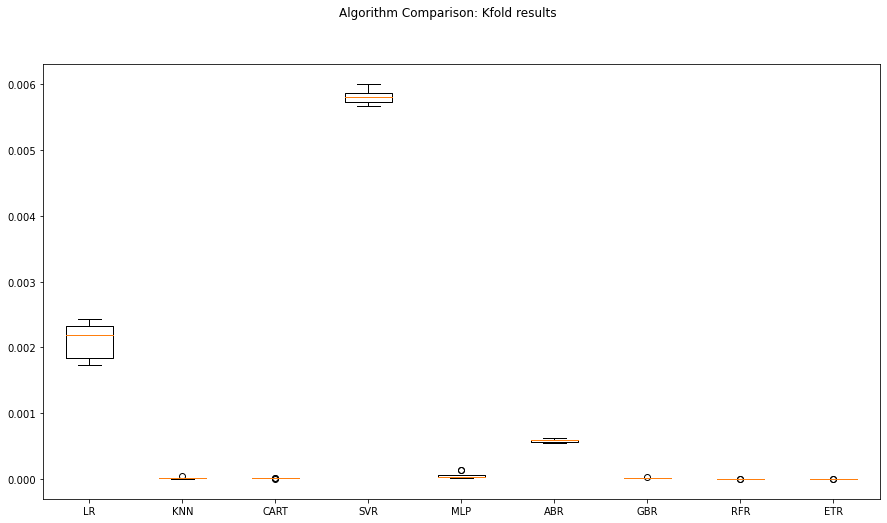

In [43]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

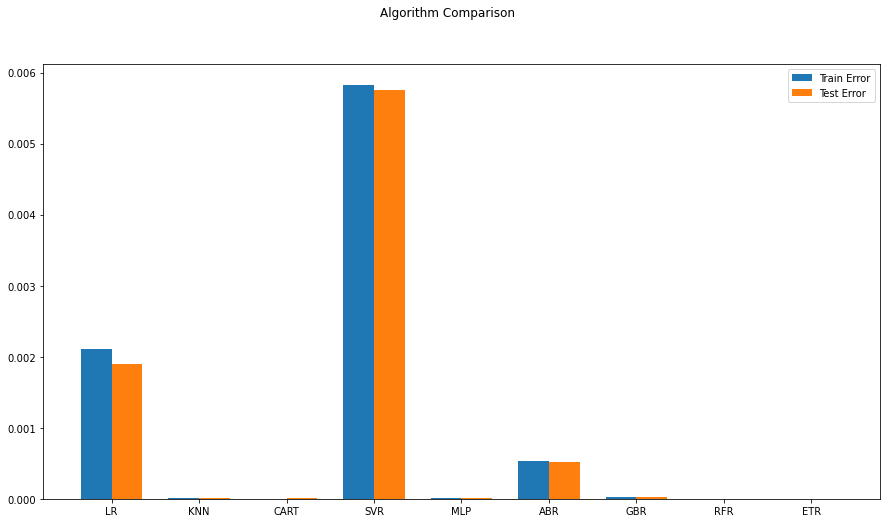

In [44]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()